# Demo notebook for CalCIL

In [1]:
import jax.numpy as jnp
import calcil as cc
import jax
from flax import linen as nn
from typing import Tuple
import matplotlib.pyplot as plt

## Define forward model

A computational imaging problem can be often written in the form of an inverse problem. Here we have a simple example of a linear inverse problem, where we have a linear operator $A$ and a vector $x$ that we want to recover from the measurement $y$. The forward model is given by:
$$y = A \cdot x.$$

Let's use a convolutional forward model as an example. We will use a point spread function (PSF) to model the blurring effect of the optical system. The forward model can be written as:

In [2]:
class ConvImager(cc.forward.Model):
    dim_yx: Tuple[int, int]
    psf: jnp.ndarray

    def setup(self):
        # assume psf has the same shape as the unknown x
        assert self.dim_yx == self.psf.shape

        # prepare for convolution by FFT
        self.psf_pad = jnp.pad(self.psf, ((self.dim_yx[0] - self.dim_yx[0] // 2, self.dim_yx[0] // 2),
                                          (self.dim_yx[1] - self.dim_yx[1] // 2, self.dim_yx[1] // 2)))
        self.f_psf_pad = jnp.fft.rfft2(jnp.fft.ifftshift(self.psf_pad, axes=(-2, -1)), axes=(-2, -1))

    def __call__(self, x):
        """Forward model"""
        pad_x = jnp.pad(x, ((self.dim_yx[0] // 2, self.dim_yx[0] - self.dim_yx[0] // 2),
                                 (self.dim_yx[1] // 2, self.dim_yx[1] - self.dim_yx[1] // 2)))
        out = jnp.fft.irfft2(jnp.fft.rfft2(pad_x, axes=(-2, -1)) * self.f_psf_pad, axes=(-2, -1))[self.dim_yx[0] // 2:-self.dim_yx[0] // 2, self.dim_yx[1] // 2:-self.dim_yx[1] // 2]

        return out

psf = jnp.array([[0, 0, 0, 0, 0],
                 [0, 0, 0.3, 0, 0],
                 [0, 0.3, 1, 0.3, 0],
                 [0, 0, 0.3, 0, 0],
                 [0, 0, 0, 0, 0]])
forward_model = ConvImager(dim_yx=(5, 5), psf=psf)

Now, given an input object $x$, we can generate the measurement $y$ by applying the forward model.

Text(0.5, 1.0, 'y')

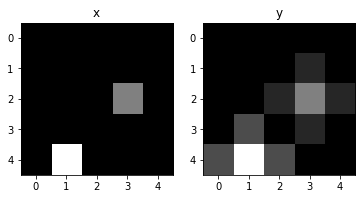

In [3]:
x = jnp.array([[0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0],
               [0, 0, 0, 1, 0],
               [0, 0, 0, 0, 0],
               [0, 2, 0, 0, 0]])

# the empty dict is for the case when we have additional parameters specified by `self.params` in the model (see more below in the reconstruction)
y = forward_model.apply({}, x=x)

f, axes = plt.subplots(1, 2)
axes[0].imshow(x, cmap='gray')
axes[0].set_title('x')
axes[1].imshow(y, cmap='gray')
axes[1].set_title('y')

## Run reconstruction (deconvolution)

Assume we don't already know the object $x$ but know the PSF used in forward model, we can run deconvolution to reconstruct $x$ from the measurement $y$.

We first rewrite the forward model in the form suitable for an inverse problem:

In [5]:
class ConvImagerInv(cc.forward.Model):
    dim_yx: Tuple[int, int]
    psf: jnp.ndarray

    def setup(self):
        # Define the unknown x
        self.x = self.param('x', nn.initializers.zeros, self.dim_yx)

        # Use the forward model defined previously
        self.conv_imager = ConvImager(dim_yx=self.dim_yx, psf=self.psf)

    def __call__(self, input_dict):
        """forward model always has a input_dict input argument"""
        y = self.conv_imager(self.x)
        return y
    
forward_model_inv = ConvImagerInv(dim_yx=(5, 5), psf=psf)

We define a dataloader which is a generator that yields a dictionary of input values each time. In this case, each dictionary contains the same measurement $y$. In general, we can use the built-in dataloader from `data_utils` module in CalCIL.

In [6]:
# prefix_dim is the shape of the batch dimension. In this case, it is (1,) since we have only one image.
data_loader = cc.data_utils.loader_from_numpy({'y': y[jnp.newaxis]}, prefix_dim=(1,))

print(next(data_loader))

n_imgs: 1, n_batches: 1.
[{'epoch': 1, 'step': 1, 'batch': 0, 'y': DeviceArray([[[ 7.21064053e-09,  1.30451321e-08, -2.07230091e-08,
               -2.14576712e-08, -1.51247748e-09],
              [-2.50738186e-08,  7.86567966e-09, -5.05019671e-09,
                3.00000012e-01,  1.17474155e-08],
              [-9.90941729e-09, -1.85088442e-08,  2.99999982e-01,
                1.00000000e+00,  3.00000012e-01],
              [-1.90734859e-08,  5.99999964e-01, -1.36727065e-08,
                2.99999982e-01,  9.45452161e-09],
              [ 5.99999964e-01,  2.00000000e+00,  6.00000024e-01,
                9.53674295e-09, -8.96148862e-08]]], dtype=float32)}]


Next, we define the loss function used for the update. Here we use the L2 loss.

In [12]:
# loss function is a callable that always takes forward_output, variables, input_dict, intermediate as arguments, and returns a scalar.
# In this case, we use a pre-defined l2 loss function getter, which only requires the input dictionary key to retrieve the measurement from the input dictionary.
l2_loss = cc.loss.get_l2_loss('y')

# register the loss function to calcil
loss = cc.loss.Loss(l2_loss, 'l2')

We need to set up the initial value for the object $x$. The initial values are stored in a structured dictionary.

There are two ways to initialize such a dictionary. One way is to use the built-in `init` function. The other way is to manually define the initial dictionary.

In [8]:
# using built-in init function to initialize the variables

# random seed is needed to pass to the init function even though it won't be used for this case (no randomness)
rng = jax.random.PRNGKey(0)
variables = forward_model_inv.init(rng, input_dict=next(data_loader)[0])

print(variables)

FrozenDict({
    params: {
        x: DeviceArray([[0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.],
                     [0., 0., 0., 0., 0.]], dtype=float32),
    },
})


Finally, we run the deconvolution algorithm to reconstruct the object $x$ from the measurement $y$.

epoch: 10, l2: 0.035520, total_loss: 0.035520, epoch per sec: 35.949
epoch: 20, l2: 0.017071, total_loss: 0.017071, epoch per sec: 566.13
epoch: 30, l2: 0.0041909, total_loss: 0.0041909, epoch per sec: 639.49
epoch: 40, l2: 0.0038545, total_loss: 0.0038545, epoch per sec: 645.98
epoch: 50, l2: 0.0013622, total_loss: 0.0013622, epoch per sec: 629.44
epoch: 60, l2: 0.00084694, total_loss: 0.00084694, epoch per sec: 648.88
epoch: 70, l2: 0.00051228, total_loss: 0.00051228, epoch per sec: 642.40
epoch: 80, l2: 0.00034189, total_loss: 0.00034189, epoch per sec: 636.50
epoch: 90, l2: 0.00025375, total_loss: 0.00025375, epoch per sec: 633.16
epoch: 100, l2: 0.00020607, total_loss: 0.00020607, epoch per sec: 627.00
epoch: 110, l2: 0.00017939, total_loss: 0.00017939, epoch per sec: 614.74
epoch: 120, l2: 0.00016568, total_loss: 0.00016568, epoch per sec: 592.52
epoch: 130, l2: 0.00015652, total_loss: 0.00015652, epoch per sec: 604.08
epoch: 140, l2: 0.00014957, total_loss: 0.00014957, epoch per

Text(0.5, 1.0, 'reconstructed x')

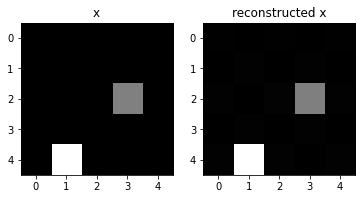

In [22]:
recon_param = cc.reconstruction.ReconIterParameters(save_dir='./checkpoint/demo_deconv', n_epoch=1000, log_every=10)

var_params = cc.reconstruction.ReconVarParameters(lr=1e-1, opt='adam')

recon, _ = cc.reconstruction.reconstruct_multivars_sgd(forward_model_inv.apply, variables, var_params,
                                                       data_loader, loss, recon_param)

f, axes = plt.subplots(1, 2)
axes[0].imshow(x, cmap='gray')
axes[0].set_title('x')
axes[1].imshow(recon['params']['x'], cmap='gray')
axes[1].set_title('reconstructed x')